# Solución del problema de las luces usando el algoritmo de Grover

### Juan Bernardo Benavides y Juan Pablo Vanegas

---

## Outline:
1. El problema de las luces
2. Algoritmo de Grover
3. Desarrollo en Qiskit
4. RAM y QRAM
5. Solución (acá va lo del 2a)
6. Solución (acá va lo del 2b)

## El problema de las luces

Imaginemos una casa embrujada(?) con muchos cuartos. Si cada vez que muevo un switch de luz hay un fantasma que mueve los switches de los cuartos vecinos, ¿cómo puedo grantizar que apago (o enciendo) las luces de toda la casa?. 

Una forma de simplificar este problema es considerar un Lattice, en donde cada celda puede contener un dígito binario, y cada vez que cambio el contenido de una celda, las celdas vecinas cambian su contenido, de acuerdo a la figura 1:

[figura 1]

El problema de las luces consiste en encontrar una serie de pasos en la que pueda dejar todos los elementos del lattice en el mismo estado.


## Algoritmo de Grover
Es un algorismo lo más de útil porque superposición y cosas

## Desarrollo en Qiskit

Qiskit es una librería de python que permite hacer simulaciones de sistemas cuánticos y pues es muy chévere.

In [9]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute

from qiskit.tools.visualization import plot_histogram

Qiskit nos permite construir un circuito cuantico, y hacer todo lo que ya sabemos hacer, pero de verdad:

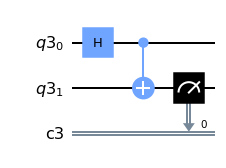

In [5]:
# Crear un circuito con dos qbits y un bit
q = QuantumRegister(2)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Compuertas
qc.h(q[0])
qc.cx(q[0], q[1])

# Medicion
qc.measure(q[1], c[0])

qc.draw(output="mpl")


{'0': 485, '1': 515}


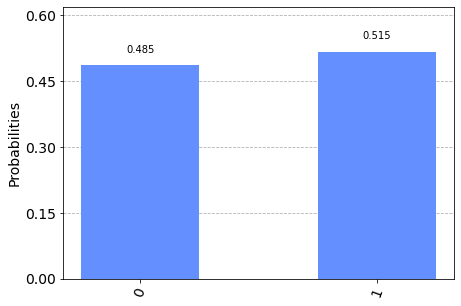

In [10]:
# simular y ver los resultados
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
count = result.get_counts()
print(count)
plot_histogram(count)


{'0': 499, '1': 501}


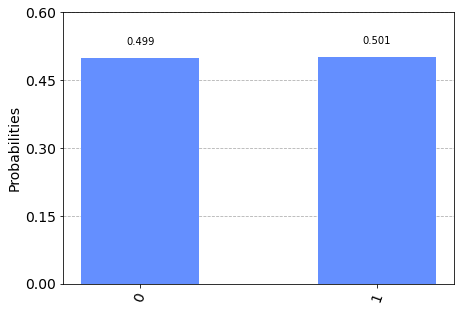

In [11]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
count = result.get_counts()
print(count)
plot_histogram(count)

## RAM y QRAM
### RAM
La RAM (Random Access Memory) es la memoria inmediata del computador. Algo así como la memoria a corto plazo de las personas. 

Carreta

Carreta

### QRAM
¿Y si seguimos en la analogía de no acabar entre clásico y cuántico? ¡Hagamos una RAM cuántica!

Carreta

### Del challenge
In classical computers, RAM (Random Access Memory) is a type of volatile memory that has memory addresses $j$ and stores binary data corresponding to each address $D_j$.

In the case of [qRAM](https://arxiv.org/abs/0708.1879) in a quantum computer, address qubits $a$ have the $N$-addresses as superposition and the corresponding binary data is stored in data qubits $d$ as a state vector.

\begin{equation}
    \sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\end{equation}

We call the right-hand side state "qRAM" and the corresponding gate operation "qRAM operation".

Although qRAM operation requires $\mathcal{O}(N\log N)$ gates, it can be used to create superposition states of binary data intuitively.  

qRAM has previously been applied to various quantum machine learning algorithms such as the HHL algorithm. For this problem, let's apply qRAM to Grover's algorithm.

In [ ]:
# implementacion en qiskit de la qram

Carreta